# Satellite time-series crop classification and clustering
## Tutorial 1: Rasterizing vector data and time-series clustering

This is the first in a three-part turorial meant to provide working examples of how to use the classes and functions avaliable in the `satTS` python library.  

**Motivation:** The exponential increase in high temporal and spatial resolution satellite data in the past ~5 years, combined with simultaous advances tools for geospatial data storage, processing, and analysis, represents a unique opportunity to derive signals and insights about our planet that were previously impossible or prohibitively resource intensive. However, many of the most successful machine learning algorithms (e.g. convolutional neural networks) do not perform well when predicting certain land use / land cover (LULC) classes using satellite images. This is especially true when trying to classify LULC that is not easily identifiable by eye, e.g., individual crop types in small fields common to developing countries. The challenge is greater when it becomes necessary to incorporate a time-series of images in order to achieve high classification accuracy, e.g. to capture the change in crop phenology over the growing season. In view of these challenges, the primary motivation for `satTS` was to build tools that allow for the easy handling and analysis of satellite image time-series data. 

**Problem:** The focus of these tutorials is a crop classification problem in southern Tanzania. Crop-type classification in developing countries using satellite data presents several unique challenges which serve to highlight the functionality of `satTS`. First, plot sizes typicaly are small, limiting the effectiveness of low-resolution satellite images. Second, field-collected, georeferenced/timestaped ground-truth training data are generally limited for key regions of interest. Third, because of the similarity in the refelctance values (data stored in satellite bands) of different crops at any given date, it is usually insufficient to use a scene from a single date to distinguish individual crops. 

The problem is broken down in to two distinct phases, whith a focus on classifying maize:

1. Rasterizing vector data generated in a GIS software to generate "ground-truth" traning, and clustering time-series of pixels from the "cropped" area LULC class, and

2. Labeling the resulting clusters as maize and "other" crop types based on patterns in their NDVI curves through the growing season. The idea is that, given a known cropping calendar for the region, and some additional domain-knowledge about growth characteristics of maize, it may be possible to label one or more clusters as maize, thereby generating a "synthetic" or "semi-synthetic" training dataset to be used to train supervised classification models. 

This tutorial focuses on **phase 1** of the process 1) rasterizing a shapefile of manually generated polygons to create a training data set comprised of a time-series of ndvi values for individual pixels, and 2) using unsupervised learning to cluster the ndvi time-series belowing to the "cropped" LULC class. [Provide additional info about the satTS library, provide link, etc.]


Step 1 - Rasterize shapefile containing polygons for broad land cover categories

In [165]:
# Load custom libraries 
from cropclass import tsmask
from cropclass import tsclust
from cropclass import tstrain

# Load helper libraries
from os import listdir
import re
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
import pickle
import gippy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Rasterize landcover shapefile

In [17]:
# File path to folder containing shapefile to be rasterized and referene image
fp = '/Users/jameysmith/Documents/sentinel2_tanz/cropclass-notebooks/data'

# File path to landcover shapefile to be rasterized
shp = fp + '/lc_polygons.shp'

# output file (rasterized land cover)
outimg = fp + '/lcrast.tif'

# Reference image (Sentinel-2 tile)
refimg = fp + '/2016-11-16_B04.jp2'

In [ ]:
For reference

In [145]:
s = '/Users/jameysmith/Documents/sentinel2_tanz/aoiTS/geotiffs/ndvi/2017-04-05_ndvi.tif'
img = gippy.GeoImage.open(filenames=[s], bandnames=['ndvi'], gain = 0.0001)

# Read band values into numpy array
ds = img.read()

In [148]:
# Deal with nodata values
ds[ds == -32768.0] = np.nan

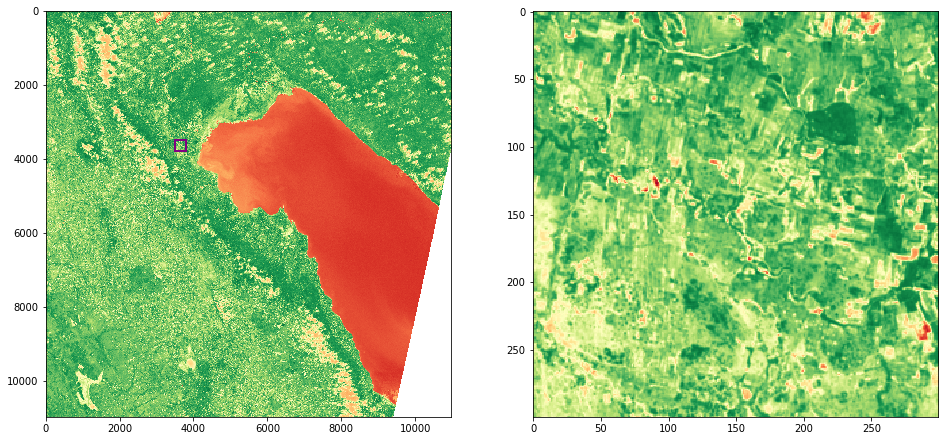

In [176]:
# Show full scene and a zoomed area
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
ax1.imshow(ds, cmap='RdYlGn'), ax2.imshow(ds[3500:3800, 3500:3800], cmap='RdYlGn')

# Zoomed area rectangle
rect = patches.Rectangle((3500, 3500), 300, 300, linewidth=2, edgecolor='purple', facecolor='none')
ax1.add_patch(rect)

In [18]:
# Perform rasterization 
tsmask.rasterize(shapefile=shp, outimg=outimg, refimg=refimg, attribute='id')

Confirm land cover polygons were correctly burned into raster layer
0 = nodata, 1 = water, 2 = veg, 3 = cropped, 4 = urban

Class 0 contains 119845316 pixels
Class 1 contains 503143 pixels
Class 2 contains 122586 pixels
Class 3 contains 83403 pixels
Class 4 contains 5952 pixels


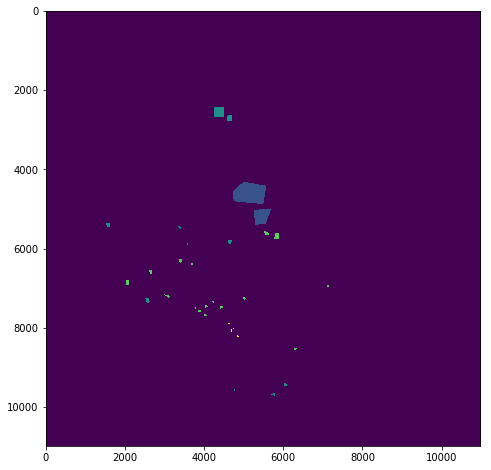

In [133]:
# Confirm land cover classes were burned into raster correctly
fig = plt.figure(figsize=(8, 8))
tsmask.check_rasterize(outimg, plot=True)

Make a time-series of NDVI bands. Not actually running in this notebook. Directory could need to contain red and nir bands organized by date (one folder per-date).

In [ ]:
# Band dictionary to match asset (band) names with variables
asset_dict = {'B02': 'blue',
              'B03': 'green',
              'B04': 'red',
              'B08': 'nir'}

scene_path = 'path/to/scenes'

In [ ]:
# Create NDVI band for each date. Writes new band to disk as GeoTIFF
tstrain.calulate_indices(scene_path, asset_dict, indices=['ndvi'])

Step 3: Create a masked time-series of the NDVI bands for each land cover class 

In [32]:
fp = '/Users/jameysmith/Documents/sentinel2_tanz/aoiTS/geotiffs/ndvi'

# List of file paths to NDVI time-series
files = [fp + '/' + f for f in listdir(fp) if not f.startswith('.')]
files.sort()

print('There were a total of ' + str(len(files)) + ' dates between November 16, 2016 and December 31, 2017 with cloud cover <15%')

There were a total of 28 dates between November 16, 2016 and December 31, 2017 with cloud cover <15%


In [36]:
# Grab dates from NDVI file names
dates = [re.findall('\d\d\d\d-\d\d-\d\d', f) for f in files]
dates = [date for sublist in dates for date in sublist]
dates[0:5]

['2016-11-16', '2017-02-14', '2017-04-05', '2017-05-05', '2017-05-15']

In [37]:
crop_mask = tsmask.mask_to_array(files, dates, outimg, 3)

`crop_mask` is a 3D array with 28 "layers" of ndvi values - one for each date in the time-series

In [39]:
crop_mask.shape

(28, 10980, 10980)

Step 4: Create a masked time-series of the NDVI bands for 'crop' land cover class 

In [40]:
cropts = tsmask.BandTimeSeries(mask=crop_mask, lc_class='crop', ts_var='ndvi', dates=dates)

In [44]:
cropts.ts_var

'ndvi'

In [46]:
cropts.mask_indices()[0:10]

[(5551, 5499),
 (5551, 5500),
 (5551, 5501),
 (5552, 5499),
 (5552, 5500),
 (5552, 5501),
 (5552, 5502),
 (5552, 5503),
 (5552, 5504),
 (5553, 5499)]

In [41]:
cropdf = cropts.time_series_dataframe(frequency='5d', interpolate=True)

In [47]:
cropdf.head()

,lc,pixel,array_index,date,ndvi
0,crop,0,"(5551, 5499)",2016-11-16,0.176800
1,crop,0,"(5551, 5499)",2016-11-21,0.200283
2,crop,0,"(5551, 5499)",2016-11-26,0.223767
3,crop,0,"(5551, 5499)",2016-12-01,0.247250
4,crop,0,"(5551, 5499)",2016-12-06,0.270733


Take a sample of the total cropped area pixels and smooth

In [117]:
cropsamp = tsclust.TimeSeriesSample(cropdf, n_samples=100, ts_var='ndvi', seed=0).smooth()

Perform clustering: Small example with 100 samples and the TimeSeariesKmeans algorithm (with Dynamic Time Warping as the distance metric) provided by the `tslearn` library. 

In [98]:
clust_df, score = tsclust.cluster_time_series(ts_sample=cropsamp, cluster_alg='TSKM', n_clusters=4, cluster_metric='dtw', score=True)

0.188 --> 0.058 --> 0.054 --> 0.053 --> 0.052 --> 0.052 --> 0.052 --> 0.052 --> 


In [99]:
score

0.3545396168715967

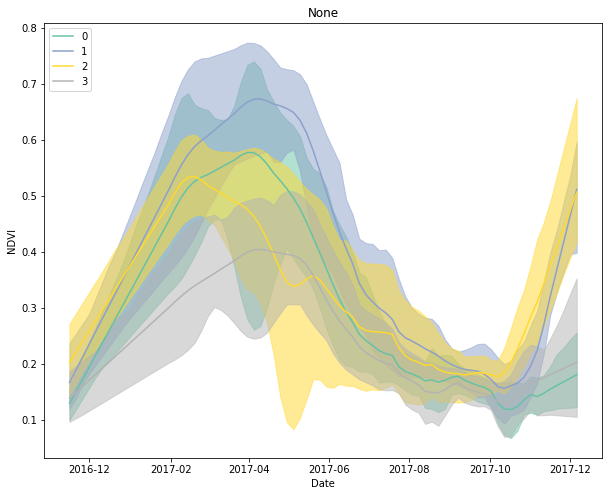

In [102]:
tsclust.plot_clusters(clust_df)

Perfor parameter grid search to find candidate clusters

In [121]:
# Number of unique pixels (time-series) is 83,403. This is the max 'n_samples' value
pg = {
    'time_seriesdf': [cropsamp],
    'n_samples': [10000],
    'cluster_alg': ['GAKM', 'TSKM'],
    'n_clusters': list(range(2, 8)),
    'smooth': [True],
    'ts_var': ['ndvi'],
    'window': [7],
    'poly': [3],
    'cluster_metric': ['dtw', 'softdtw'],
    'score': [True]
}

In [ ]:
pg_dict, pg_df = tsclust.cluster_grid_search(pg)

In [126]:
clust_4 = pd.read_csv('/Users/jameysmith/Documents/sentinel2_tanz/clustering/cluster_results/smooth_results/final_clusters/4_clusters.csv')

In [127]:
clust_4.head()

,lc,pixel,array_index,2016-11-16,2016-11-21,2016-11-26,2016-12-01,2016-12-06,2016-12-11,2016-12-16,...,2017-10-27,2017-11-01,2017-11-06,2017-11-11,2017-11-16,2017-11-21,2017-11-26,2017-12-01,2017-12-06,cluster
0,crop,8,"(5552, 5504)",0.1336,0.155572,0.177544,0.199517,0.221489,0.243461,0.265433,...,0.100786,0.115090,0.148286,0.199071,0.258300,0.311900,0.365500,0.419100,0.4727,2
1,crop,34,"(5555, 5505)",0.0835,0.095661,0.107822,0.119983,0.132144,0.144306,0.156467,...,0.101120,0.116246,0.140287,0.171373,0.206186,0.238514,0.270843,0.303171,0.3355,1
2,crop,48,"(5556, 5506)",0.0948,0.104278,0.113756,0.123233,0.132711,0.142189,0.151667,...,0.103773,0.111533,0.133206,0.169313,0.212043,0.250357,0.288671,0.326986,0.3653,1
3,crop,51,"(5556, 5509)",0.1023,0.109600,0.116900,0.124200,0.131500,0.138800,0.146100,...,0.113071,0.125078,0.144938,0.178576,0.217971,0.253529,0.289086,0.324643,0.3602,1
4,crop,52,"(5556, 5510)",0.1126,0.118300,0.124000,0.129700,0.135400,0.141100,0.146800,...,0.102627,0.114010,0.142746,0.183792,0.231257,0.274443,0.317629,0.360814,0.4040,2


In [129]:
results = pd.read_csv('/Users/jameysmith/Documents/sentinel2_tanz/clustering/cluster_results/smooth_results/gridsearch_results.csv')

In [130]:
results

,cluster_alg,cluster_metric,n_clusters,score,sil_score
0,GAKM,dtw,2,True,0.253311
1,GAKM,softdtw,2,True,0.220138
2,GAKM,dtw,3,True,0.133689
3,GAKM,softdtw,3,True,0.130685
4,GAKM,dtw,4,True,0.145107
5,GAKM,softdtw,4,True,0.142953
6,GAKM,dtw,5,True,0.133328
7,GAKM,softdtw,5,True,0.155957
8,GAKM,dtw,6,True,0.149439
9,GAKM,softdtw,6,True,0.129197


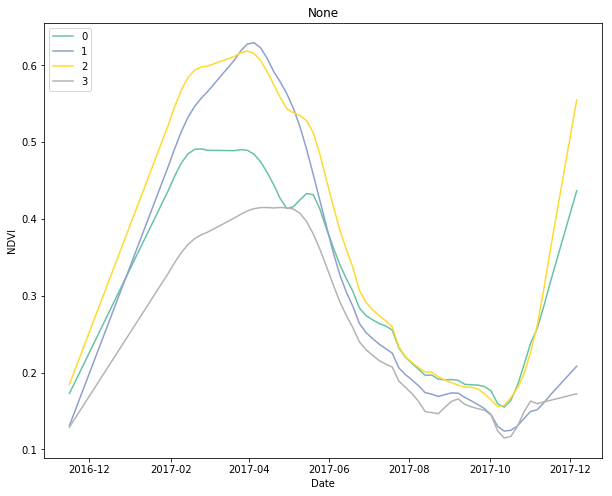

In [132]:
tsclust.plot_clusters(clust_4, fill=False)